## Fitting an ionic cluster expansion with energy centering
Determining a good center for data can speed up optimization model solving and lead to sparser, more physical solutions for complex systems. Here we pick up from "lmo-drx-ce-mc.ipynb" and fit the data in a different way, using L1 regularization.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
from monty.serialization import loadfn
from pymatgen.core.structure import Structure
from smol.cofe import ClusterSubspace, StructureWrangler, ClusterExpansion, RegressionData
from smol.io import load_work

### Load the LMO DRX prim

In [6]:
prim = loadfn("data/lmo_drx_prim.json")
prim

If you see this text, the Crystal Toolkit Jupyter Lab 

extension is not installed. You can install it by running 

"pip install crystaltoolkit-extension" 

from the same environment you run "jupyter lab". 

This only works in Jupyter Lab 3.x or above.


Structure Summary
Lattice
    abc : 2.96985 2.9698500000000005 2.96985
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 18.522028420882272
      A : 2.571965545429215 0.0 1.4849250000000003
      B : 0.8573218484764051 2.4248723708682074 1.4849250000000003
      C : 0.0 0.0 2.96985
Overall Charge: +1.5
PeriodicSite: Li+:0.250, Mn2+:0.250 (2.5720, 1.8187, 4.4548) [0.7500, 0.7500, 0.7500]
PeriodicSite: Li+:0.250, Mn2+:0.250 (0.8573, 0.6062, 1.4849) [0.2500, 0.2500, 0.2500]
PeriodicSite: Li+:0.200, Mn2+:0.200, Mn3+:0.200, Mn4+:0.200 (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: O2- (1.7146, 1.2124, 2.9699) [0.5000, 0.5000, 0.5000]

In [5]:
print(prim)

Full Formula (Li0.7 Mn1.1 O1)
Reduced Formula: Li0.7Mn1.1O1
abc   :   2.969850   2.969850   2.969850
angles:  60.000000  60.000000  60.000000
Overall Charge: +1.5
Sites (4)
  #  SP                                                a     b     c
---  ---------------------------------------------  ----  ----  ----
  0  Li+:0.250, Mn2+:0.250                          0.75  0.75  0.75
  1  Li+:0.250, Mn2+:0.250                          0.25  0.25  0.25
  2  Li+:0.200, Mn2+:0.200, Mn3+:0.200, Mn4+:0.200  0     0     0
  3  O2-                                            0.5   0.5   0.5


## 1) Create the cluster subspace

In [18]:
from smol.cofe import ClusterSubspace
from smol.cofe.extern import EwaldTerm

CLUSTERCUTOFFS = {2: 6, 3: 4, 4:2}
LTOL, STOL, ATOL = 0.15, 0.20, 15
BASIS = 'sinusoid'

cs = ClusterSubspace.from_cutoffs(structure=prim,
                                  cutoffs = CLUSTERCUTOFFS,
                                  ltol = LTOL, 
                                  stol = STOL, 
                                  angle_tol = ATOL,
                                  supercell_size = ('O2-'),
                                  basis = BASIS, 
                                  orthonormal=False)
cs.add_external_term(EwaldTerm())

## 2) Load data into a Structure Wrangler

In [20]:
# load the training structures with oxidation state assigned
from monty.serialization import loadfn

entries = loadfn("data/lmo_drx_entries.json")

In [21]:
from smol.cofe import StructureWrangler

sw = StructureWrangler(cs)
for entry in entries:
    sw.add_entry(entry, verbose=False)

In [22]:
print ('Our feature matrix has the following dimensions:', 
       sw.feature_matrix.shape)

Our feature matrix has the following dimensions: (238, 387)


In [99]:
print(sw.cluster_subspace)

Basis/Orthogonal/Orthonormal : sinusoid/True/False
       Unit Cell Composition : Li+0.7 Mn2+0.7 Mn3+0.2 Mn4+0.2 O2-1
            Number of Orbits : 40
No. of Correlation Functions : 386
             Cluster Cutoffs : 2: 5.94, 3: 3.64
              External Terms : [EwaldTerm(total)]
Orbit Summary
 ------------------------------------------------------------------------
 |  ID     Degree    Cluster Diameter    Multiplicity    No. Functions  |
 |   0       0             NA                 0                1        |
 |   1       1            0.0000              2                2        |
 |   2       1            0.0000              1                4        |
 |   3       2            1.8187              8                8        |
 |   4       2            2.1000              6                3        |
 |   5       2            2.9698              12               3        |
 |   6       2            2.9699              6               10        |
 |   7       2            3.4825   

## 3) Perform a "piecewise fit", with the first fit only using the Points and Ewald features.

In [23]:
from smol.cofe.wrangling.tools import unique_corr_vector_indices
unique_inds = unique_corr_vector_indices(sw, 'energy')

In [32]:
unique_energies = sw.get_property_vector('energy')[unique_inds]
print(f'There are {len(unique_inds)} unique structure to train on.')
avg_en = np.average(unique_energies)
std_en = np.std(unique_energies)
print(f'The average energy is {avg_en}, while the std. dev. is {std_en} eV/prim')

There are 170 unique structure to train on.
The average energy is -20.41894778320028, while the std. dev. is 1.4573599233718875 eV/prim


#### Determine the feature matrix column indeces of Points and Ewald features

In [104]:
point_inds = sw.cluster_subspace.function_inds_by_size[1]
ewald_ind = sw.feature_matrix.shape[1] - 1
print(f'The point indeces are {point_inds}, while the Ewald index is {ewald_ind}')
initial_fit_cols = np.concatenate([point_inds, [ewald_ind]])
initial_fit_cols

The point indeces are [1, 2, 3, 4, 5, 6], while the Ewald index is 386


array([  1,   2,   3,   4,   5,   6, 386])

### Perform initial fit with only Points and Ewald features, and determine the intercept.

In [29]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold, GridSearchCV

In [105]:
lasso = Lasso(alpha=1e-6, fit_intercept=True, max_iter=int(1e7))
lasso.fit(sw.feature_matrix[unique_inds][:, initial_fit_cols], unique_energies)
print(lasso.coef_, lasso.intercept_)

[-6.80864145  9.17087773  1.23408451  4.73489259 -3.1117202  -0.46576228
  0.05446231] -23.111363120607102


In [107]:
initial_coefs = np.concatenate([[lasso.intercept_], lasso.coef_])
print(initial_coefs)

[-23.11136312  -6.80864145   9.17087773   1.23408451   4.73489259
  -3.1117202   -0.46576228   0.05446231]


In [183]:
print(f'The effective dielectric constant is {1 / initial_coefs[-1]}')

The effective dielectric constant is 18.361322767174926


### Let's visualize the variance that these features can capture. To do so, we plot the "centered energies" by subtracting the DFT energies by the contributions from the fitted Point and Ewald features.

Text(0.5, 1.0, 'Centered energies')

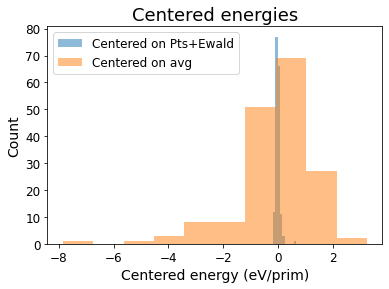

In [197]:
centered_energies = unique_energies - np.dot(sw.feature_matrix[unique_inds][:, np.concatenate([[0], initial_fit_cols])], initial_coefs)
plt.hist(centered_energies, alpha=0.5, label='Centered on Pts+Ewald')
plt.hist(unique_energies - avg_en, alpha=0.5, label='Centered on avg')
plt.xlabel('Centered energy (eV/prim)', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Count', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.title('Centered energies', fontsize=18)

Text(0.5, 1.0, 'A closer look at the centered energies')

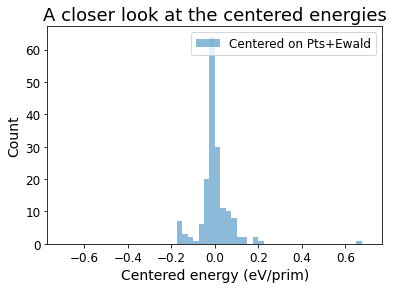

In [206]:
bins = np.arange(-0.7, 0.71, 0.025)
plt.hist(centered_energies, bins=bins, alpha=0.5, label='Centered on Pts+Ewald')
plt.xlabel('Centered energy (eV/prim)', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Count', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.title('A closer look at the centered energies', fontsize=18)

In [207]:
print(f'The variance of DFT energies is {np.std(unique_energies)}, while the variance of the centered energy is {np.std(centered_energies)} eV/prim')

0.07965979068909568


## 4) Perform cross validation on the rest of features to train the L1 hyperparameter.

In [131]:
initial_fit_cols

array([  1,   2,   3,   4,   5,   6, 386])

In [132]:
high_order_cols = set(np.arange(sw.feature_matrix.shape[1])) - set(initial_fit_cols) - set([0])
high_order_cols = list(high_order_cols)

In [143]:
alpha_scan = np.logspace(-6, -3, 50)  # range of L1 hyperparameters to scan
rkf = RepeatedKFold(n_repeats=1, n_splits=5)

In [144]:
test_inds = [test for train, test in rkf.split(sw.feature_matrix[unique_inds], unique_energies)]
train_inds = [train for train, test in rkf.split(sw.feature_matrix[unique_inds], unique_energies)]

In [145]:
from sklearn.metrics import mean_squared_error

test_errs = []
train_errs = []

for alpha in alpha_scan:
    print(f'Fkey= hyperparameter {alpha}')
    lasso = Lasso(alpha=alpha,
                  fit_intercept=False,
                  max_iter=int(1e7)
                 )
    test_rmses = []
    
    # Cross validation fits
    for train_index, test_index in zip(train_inds, test_inds):
        act_train_inds = [unique_inds[ind] for ind in train_index]  # Adjust indices to reflect actual feature matrix rows
        act_test_inds = [unique_inds[ind] for ind in test_index]
        
        lasso.fit(sw.feature_matrix[act_train_inds][:, high_order_cols], centered_energies[train_index])  # Fit high order terms on the centered energies
        all_coefs = np.concatenate([initial_coefs[:-1], lasso.coef_, [initial_coefs[-1]]])
        this_pred = np.dot(sw.feature_matrix[act_test_inds], all_coefs)  # Predictions on test set
        this_test = mean_squared_error(this_pred, sw.get_property_vector('energy')[act_test_inds], squared=False)
        test_rmses.append(this_test)
    test_errs.append(test_rmses)
    print(f'Average and std of test errors are {np.average(test_errs)}, {np.std(test_errs)}')
    
    # Fit on entire training set
    full_fit = Lasso(alpha=alpha, fit_intercept=False, max_iter=int(1e7))
    full_fit.fit(sw.feature_matrix[unique_inds][:, high_order_cols], centered_energies)
    all_coefs = np.concatenate([initial_coefs[:-1], full_fit.coef_, [initial_coefs[-1]]])
    preds = np.dot(sw.feature_matrix[unique_inds], all_coefs)
    train_rmse = mean_squared_error(preds, sw.get_property_vector('energy')[unique_inds], squared=False)
    train_errs.append(train_rmse)
    print(f'Training error is {train_rmse}')
    

For hyperparameter 1e-06
Average and std of test errors are 0.023563371828414968, 0.006944566676647027
Training error is 0.012781053174431387
For hyperparameter 1.151395399326448e-06
Average and std of test errors are 0.02293354971559951, 0.006704246228834625
Training error is 0.0128531409875664
For hyperparameter 1.325711365590108e-06
Average and std of test errors are 0.022491265306204898, 0.006497581056875485
Training error is 0.01294077039585756
For hyperparameter 1.5264179671752333e-06
Average and std of test errors are 0.02248162195120036, 0.006500252501135466
Training error is 0.013021795190002268
For hyperparameter 1.757510624854793e-06
Average and std of test errors are 0.022634686221190584, 0.0066889555610161735
Training error is 0.013116645073882102
For hyperparameter 2.0235896477251557e-06
Average and std of test errors are 0.022829775463764936, 0.006885748019031812
Training error is 0.01321298400262933
For hyperparameter 2.3299518105153717e-06
Average and std of test error

#### Plot the cross validation trials

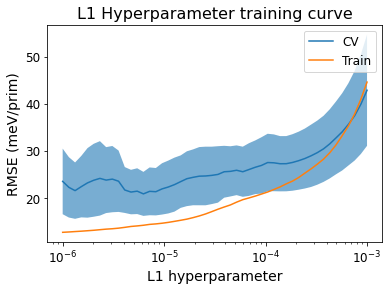

In [184]:
mean_cvs = 1000 * np.array([np.average(tests) for tests in test_errs])
std_cvs = 1000 * np.array([np.std(tests) for tests in test_errs])
plt.plot(alpha_scan, mean_cvs, label='CV')
plt.fill_between(alpha_scan,
                 mean_cvs + std_cvs,
                 mean_cvs - std_cvs,
                 alpha=0.6
                )
                 
plt.plot(alpha_scan, 1000 * np.array(train_errs), label='Train')
plt.xscale('log')
plt.xlabel('L1 hyperparameter', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('RMSE (meV/prim)', fontsize=14)
plt.yticks(fontsize=12)
plt.title('L1 Hyperparameter training curve', fontsize=16)
plt.legend(fontsize=12)

In [152]:
# Find the optimal hyperparameter that minimizes the CV score
sorted_mean_cvs = sorted([(i, cv) for (i, cv) in enumerate(mean_cvs)], key=lambda t: t[1])

[(13, 20.919178970324158),
 (11, 21.304634756308214),
 (15, 21.38028596507715),
 (14, 21.45740580491836),
 (12, 21.495039780587),
 (2, 21.606696487415693),
 (10, 21.741839639121704),
 (16, 21.976003202067727),
 (1, 22.30372760278405),
 (17, 22.37097685881364)]

In [160]:
opt_alpha = alpha_scan[sorted_mean_cvs[0][0]]
print(f'The optimal hyperparameter is {opt_alpha}')

The optimal hyperparameter is 6.250551925273976e-06


## 5) Obtain the cluster expansion model that minimizes CV

In [186]:
final_fit = Lasso(alpha=opt_alpha, fit_intercept=False, max_iter=int(1e7))
final_fit.fit(sw.feature_matrix[unique_inds][:, high_order_cols], centered_energies)
all_coefs = np.concatenate([initial_coefs[:-1], final_fit.coef_, [initial_coefs[-1]]])

In [159]:
reg_data = RegressionData.from_sklearn(
    final_fit, sw.feature_matrix[unique_inds], unique_energies
)

expansion = ClusterExpansion(
    sw.cluster_subspace, coefficients=all_coefs, regression_data=reg_data
)

## 6) Get an idea of the predictive capabilities of this cluster expansion

In [165]:
first_inds = [(size, inds[0]) for size, inds in sw.cluster_subspace.function_inds_by_size.items()]
first_inds

[(1, 1), (2, 7), (3, 112)]

Out-of-sample RMSE is: 0.01142790133610809 eV/prim
In-sample RMSE is: 0.014902570493376914 eV/prim
Number of Features > 1E-5: 69/387
Point correlation coeficients: [-23.11136312  -6.80864145   9.17087773   1.23408451   4.73489259
  -3.1117202   -0.46576228]


Text(0, 0.5, 'Magnitude |$w_i$| eV/prim')

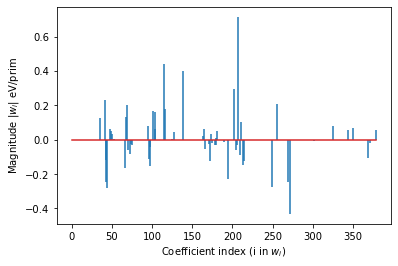

In [163]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    sw.feature_matrix[unique_inds], unique_energies,
    test_size=0.2
)

final_fit = Lasso(alpha=opt_alpha, fit_intercept=False, max_iter=int(1e7))
final_fit.fit(sw.feature_matrix[unique_inds][:, high_order_cols], centered_energies)
all_coefs = np.concatenate([initial_coefs[:-1], final_fit.coef_, [initial_coefs[-1]]])

y_predict = np.dot(X_test, all_coefs)
y_train_predict = np.dot(X_train, all_coefs)
print(f'Out-of-sample RMSE is: {mean_squared_error(y_test, y_predict, squared=False)} eV/prim')
print(f'In-sample RMSE is: {mean_squared_error(y_train, y_train_predict, squared=False)} eV/prim')
print(f'Number of Features > 1E-5: {sum(np.abs(all_coefs) > 1E-5)}/{len(all_coefs)}')

first_pair = sw.cluster_subspace.orbits_by_size[2][0].bit_id
print(f'Point correlation coeficients: {all_coefs[:first_pair]}')
# plot the coefficients (excluding those for points))
plt.stem(range(len(all_coefs) - first_pair), all_coefs[first_pair:],
         linefmt='-', markerfmt=' ')#, basefmt=' ')
plt.xlabel('Coefficient index (i in $w_i$)')
plt.ylabel('Magnitude |$w_i$| eV/prim')

## 7) Plot the ECI

In [167]:
reg_data = reg_data = RegressionData.from_sklearn(
    final_fit, sw.feature_matrix[unique_inds], unique_energies
)
expansion = ClusterExpansion(cluster_subspace=sw.cluster_subspace,
                             coefficients=all_coefs,
                             regression_data=reg_data
                            )
                             

(array([-60., -40., -20.,   0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

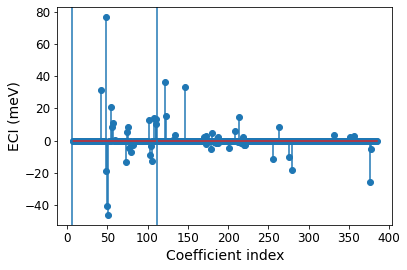

In [189]:
plt.stem(np.arange(7, len(expansion.eci)), 1000 * expansion.eci[7:])  # Plot ECI of pairs and triplets
for t in first_inds[1:]:  # vertical lines denotes where points, pairs, and triplets cut off
    plt.axvline(t[1]-0.5)
plt.xlabel('Coefficient index', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('ECI (meV)', fontsize=14)
plt.yticks(fontsize=12)